In [1]:
#6->1->6

## Imports

In [2]:
import random

import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

import torch
from torchvision import datasets, transforms

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tomut\anaconda3\envs\qhack2022\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e1_classic
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Get Data

In [4]:
input_data = get_dataset(img_width=8, img_height=8, train=True)
print("Original data set size:", len(input_data))

# Select only the pictures with numbers 0 or 1. (jus to compare with literature)
filtered_data = [image for image in input_data if image[1] in [0, 1]]
input_data = filtered_data
print("Final data set szize:", len(input_data))

Original data set size: 60000
Final data set szize: 12665


## Training node

In [5]:
shots = 2500
nr_trash=5
nr_latent=1
nr_ent=0
spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent)
print("Qubits:", spec.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec.num_qubits)

Qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [6]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state):
    #initilaization
    setAB_amplitude(spec, *init_params)

    setAux(spec, reinit_state)

    setEnt(spec, inputs=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2)])

    #encoder

    for params in encoder_params:
        e1_classic(params, [*spec.latent_qubits, *spec.trash_qubits])

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

## Training parameters 

In [7]:
epochs = 2000
learning_rate = 0.0003
batch_size = 5
num_samples = 20

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [8]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [9]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [10]:
def fidelity(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [11]:
def iterate_batches(X, batch_size):
    X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in X]
    X2 = []
    for i in range(len(X1)):
        X2.append([X1[1], X[i][1]])
    X = X2
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [12]:
training_data = [input_data[i] for i in range(num_samples)]
test_data = [input_data[i] for i in range(num_samples,num_samples+num_samples)]

In [13]:
X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in training_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_training = X2

X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in test_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_tes = X2

In [14]:
# initialize random encoder parameters
nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder = 2 * 3 * nr_encod_qubits + 3 * (nr_encod_qubits - 1) * nr_encod_qubits
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)


###  training

In [15]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch:0 | Loss:1.9753552777966807 | Fidelity:0.5062380480312403
Test-Epoch:0 | Loss:1.9674542850393943 | Fidelity:0.508271021900759
Epoch:5 | Loss:1.9711040514944618 | Fidelity:0.507329889176482
Test-Epoch:5 | Loss:1.9639479288259316 | Fidelity:0.5091784692060599
Epoch:10 | Loss:1.96628121988523 | Fidelity:0.5085742516822538
Test-Epoch:10 | Loss:1.95994043512006 | Fidelity:0.5102195873308482
Epoch:15 | Loss:1.960720608646011 | Fidelity:0.5100165702295325
Test-Epoch:15 | Loss:1.9552394801089747 | Fidelity:0.511446301168318
Epoch:20 | Loss:1.9542962998304987 | Fidelity:0.5116931348059824
Test-Epoch:20 | Loss:1.9497557520431734 | Fidelity:0.5128847543863315
Epoch:25 | Loss:1.9469001515405424 | Fidelity:0.5136370240706594
Test-Epoch:25 | Loss:1.943406652638437 | Fidelity:0.5145603462056514
Epoch:30 | Loss:1.9384287218823455 | Fidelity:0.5158817493319707
Test-Epoch:30 | Loss:1.93611276339918 | Fidelity:0.5164988418568799
Epoch:35 | Loss:1.9287892652116276 | Fidelity:0.5184599572573207
Test-

Test-Epoch:300 | Loss:1.326720866760552 | Fidelity:0.7537380507489079
Epoch:305 | Loss:1.2747131178902709 | Fidelity:0.7844902401687542
Test-Epoch:305 | Loss:1.3189719821178219 | Fidelity:0.7581662185077954
Epoch:310 | Loss:1.2672507740960517 | Fidelity:0.7891097961359024
Test-Epoch:310 | Loss:1.3113124184093037 | Fidelity:0.7625947760130702
Epoch:315 | Loss:1.259897909867451 | Fidelity:0.7937151035556572
Test-Epoch:315 | Loss:1.3037556236135055 | Fidelity:0.7670149082298008
Epoch:320 | Loss:1.2526682232520803 | Fidelity:0.7982959744950479
Test-Epoch:320 | Loss:1.2963146411409214 | Fidelity:0.7714176545285892
Epoch:325 | Loss:1.2455748484656934 | Fidelity:0.8028421585678343
Test-Epoch:325 | Loss:1.2890019185191046 | Fidelity:0.7757940353951297
Epoch:330 | Loss:1.2386301306865262 | Fidelity:0.8073435121796511
Test-Epoch:330 | Loss:1.2818291279216782 | Fidelity:0.7801351819968173
Epoch:335 | Loss:1.2318454154312637 | Fidelity:0.8117901706440203
Test-Epoch:335 | Loss:1.2748070020115752 | 

Epoch:605 | Loss:1.0733453200348966 | Fidelity:0.9316666140282678
Test-Epoch:605 | Loss:1.1042699154684157 | Fidelity:0.905575698470255
Epoch:610 | Loss:1.0723421969936706 | Fidelity:0.9325381420254809
Test-Epoch:610 | Loss:1.1032237390687174 | Fidelity:0.9064344471450065
Epoch:615 | Loss:1.071366194475144 | Fidelity:0.9333876737541582
Test-Epoch:615 | Loss:1.1022087375124356 | Fidelity:0.9072691641484264
Epoch:620 | Loss:1.070416319272837 | Fidelity:0.9342159513032531
Test-Epoch:620 | Loss:1.101223669428503 | Fidelity:0.908080735786369
Epoch:625 | Loss:1.0694916161853567 | Fidelity:0.9350236924406957
Test-Epoch:625 | Loss:1.1002673409486676 | Fidelity:0.9088700198424359
Epoch:630 | Loss:1.0685911662300465 | Fidelity:0.9358115915630913
Test-Epoch:630 | Loss:1.0993386040105286 | Fidelity:0.9096378462030458
Epoch:635 | Loss:1.0677140850084375 | Fidelity:0.9365803205566008
Test-Epoch:635 | Loss:1.0984363547536624 | Fidelity:0.9103850174589884
Epoch:640 | Loss:1.0668595212030296 | Fidelity

Test-Epoch:905 | Loss:1.0707088454078941 | Fidelity:0.9339607161076948
Epoch:910 | Loss:1.039237013253017 | Fidelity:0.9622444035839356
Test-Epoch:910 | Loss:1.07039777403971 | Fidelity:0.9342321371110227
Epoch:915 | Loss:1.0388968594341903 | Fidelity:0.9625594599878046
Test-Epoch:915 | Loss:1.0700906989332268 | Fidelity:0.9345002260059833
Epoch:920 | Loss:1.0385591372431784 | Fidelity:0.9628724683453921
Test-Epoch:920 | Loss:1.0697875261046301 | Fidelity:0.934765059040514
Epoch:925 | Loss:1.038223728222412 | Fidelity:0.9631835343545309
Test-Epoch:925 | Loss:1.06948816188579 | Fidelity:0.9350267124385331
Epoch:930 | Loss:1.0378905175457525 | Fidelity:0.9634927606474811
Test-Epoch:930 | Loss:1.0691925125494068 | Fidelity:0.9352852627218434
Epoch:935 | Loss:1.0375593938225764 | Fidelity:0.9638002469582005
Test-Epoch:935 | Loss:1.0689004839577279 | Fidelity:0.9355407870126354
Epoch:940 | Loss:1.0372302489049114 | Fidelity:0.9641060902878426
Test-Epoch:940 | Loss:1.0686119812370243 | Fidel

Epoch:1205 | Loss:1.020882450301722 | Fidelity:0.979544706351304
Test-Epoch:1205 | Loss:1.0557402264634892 | Fidelity:0.9472027066258452
Epoch:1210 | Loss:1.020598262175802 | Fidelity:0.9798174630124412
Test-Epoch:1210 | Loss:1.0555181856606952 | Fidelity:0.9474019619795143
Epoch:1215 | Loss:1.0203171206695318 | Fidelity:0.980087445110987
Test-Epoch:1215 | Loss:1.0552980681585284 | Fidelity:0.9475995741610499
Epoch:1220 | Loss:1.0200392254421815 | Fidelity:0.9803544560421251
Test-Epoch:1220 | Loss:1.055080046267721 | Fidelity:0.9477953862718159
Epoch:1225 | Loss:1.0197647707696347 | Fidelity:0.9806183040087589
Test-Epoch:1225 | Loss:1.0548642905962706 | Fidelity:0.9479892427060375
Epoch:1230 | Loss:1.0194939439251018 | Fidelity:0.9808788036051995
Test-Epoch:1230 | Loss:1.0546509685995926 | Fidelity:0.9481809904634512
Epoch:1235 | Loss:1.0192269236272262 | Fidelity:0.9811357773411229
Test-Epoch:1235 | Loss:1.0544402431902467 | Fidelity:0.9483704804119238
Epoch:1240 | Loss:1.018963878580

Test-Epoch:1500 | Loss:1.0480313350714678 | Fidelity:0.9541699437181494
Epoch:1505 | Loss:1.0107209036722555 | Fidelity:0.9893928149370378
Test-Epoch:1505 | Loss:1.0479775365384068 | Fidelity:0.9542189265841687
Epoch:1510 | Loss:1.0106303978806834 | Fidelity:0.9894814188223752
Test-Epoch:1510 | Loss:1.0479248659483178 | Fidelity:0.9542668873450687
Epoch:1515 | Loss:1.0105407168717577 | Fidelity:0.9895692309119543
Test-Epoch:1515 | Loss:1.0478732611634387 | Fidelity:0.9543138822816356
Epoch:1520 | Loss:1.010451815032868 | Fidelity:0.9896562954538041
Test-Epoch:1520 | Loss:1.0478226620981987 | Fidelity:0.9543599658338774
Epoch:1525 | Loss:1.010363649706553 | Fidelity:0.9897426538360093
Test-Epoch:1525 | Loss:1.0477730107051957 | Fidelity:0.9544051906118083
Epoch:1530 | Loss:1.0102761810794407 | Fidelity:0.9898283446923781
Test-Epoch:1530 | Loss:1.0477242509540616 | Fidelity:0.9544496074128247
Epoch:1535 | Loss:1.0101893720708515 | Fidelity:0.9899134040086326
Test-Epoch:1535 | Loss:1.0476

Epoch:1800 | Loss:1.0061722609985346 | Fidelity:0.9938656021063338
Test-Epoch:1800 | Loss:1.0454759776867557 | Fidelity:0.9565021304579597
Epoch:1805 | Loss:1.0061068723909086 | Fidelity:0.9939301951328531
Test-Epoch:1805 | Loss:1.045432579642829 | Fidelity:0.9565418368171091
Epoch:1810 | Loss:1.0060419549745787 | Fidelity:0.9939943310070692
Test-Epoch:1810 | Loss:1.045389033217673 | Fidelity:0.956581682248984
Epoch:1815 | Loss:1.0059775163477798 | Fidelity:0.9940580020421523
Test-Epoch:1815 | Loss:1.0453453441869567 | Fidelity:0.9566216615024722
Epoch:1820 | Loss:1.0059135642388914 | Fidelity:0.9941212004200718
Test-Epoch:1820 | Loss:1.0453015189540387 | Fidelity:0.9566617687503512
Epoch:1825 | Loss:1.0058501064965373 | Fidelity:0.9941839182013773
Test-Epoch:1825 | Loss:1.0452575645513704 | Fidelity:0.9567019975877475
Epoch:1830 | Loss:1.0057871510781289 | Fidelity:0.9942461473365161
Test-Epoch:1830 | Loss:1.0452134886421933 | Fidelity:0.9567423410303204
Epoch:1835 | Loss:1.0057247060

## Rezults

In [16]:
import matplotlib.pyplot as plt

fidelity: 0.995974714614816


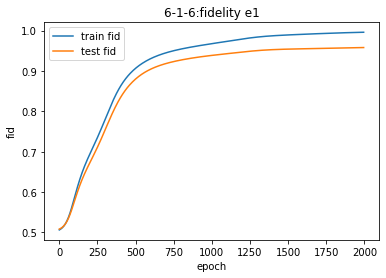

In [17]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")


plt.legend()
plt.title("6-1-6:fidelity e1",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

loss: 1.0040415537925989


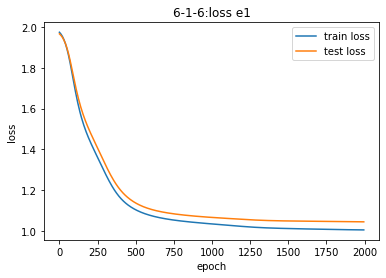

In [18]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("6-1-6:loss e1",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])

In [19]:
name = "training_e1"

Circuit_prop={   "shots":shots, "nr_trash":nr_trash, "nr_latent":nr_latent ,"nr_ent":nr_ent  }
Training_param = { "num_samples": num_samples,
                    "batch_size": batch_size,
                    "nr_layers": 1,
                    "epochs": epochs,
                    "learning_rate":learning_rate ,
                    "beta1":beta1,
                    "beta2 ":beta2,
                     "optimizer":"Adam"}

performance={"loss_hist":loss_hist, "fid_hist":fid_hist,
             "loss_hist_test":loss_hist_test, "fid_hist_test":fid_hist_test,
             "encoder_params":encoder_params}

experiment_data={"Circuit_prop":Circuit_prop,
                "Training_param":Training_param,
                "performance:":performance,
                "Name":name}

# open file for writing
f = open(name+".txt","w")
f.write( str(experiment_data) )

66060